In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1
env: CUDA_LAUNCH_BLOCKING=1


In [2]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
np.random.seed(0)

import os
# from datetime import datetime
from os import path
from tqdm.auto import tqdm, trange

In [3]:
# Models
import torch
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch.nn as nn
from transformers import WEIGHTS_NAME, CONFIG_NAME, AdamW
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup

In [4]:
# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [5]:
from config import Config
from dataset import *

from semisupervised.model import (
    SequenceRegressionModel, 
    MODEL_CLASSES
)
from semisupervised.utils import (
    evaluate, 
    evaluate_metrics, 
    evaluate_test_metrics,
    save_metrics, 
    load_metrics, 
    predict_ensemble
)

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

In [6]:
# dateTimeObj = datetime.now()

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument('--num_epochs', type=int, default=10)
parser.add_argument('--learning_rate', type=float, default=2e-5)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--ens_iter', type=int, default=2)
parser.add_argument('--thresh', type=float, default=0.9)
parser.add_argument('--label', type=str, default='Information_discrete')
parser.add_argument('--normalize_label', type=bool, default=True)
parser.add_argument('--early_stopping_thresh', type=float, default=0.1)
parser.add_argument('--model_path', type=str, default='models/hard_Information_discrete_Normalized_distil')
parser.add_argument('--eval_bs', type=int, default=200)

# args = parser.parse_args()
args = parser.parse_args(args=[])
print (args)

if not path.isdir(args.model_path):
    os.mkdir(args.model_path)

import json
with open(args.model_path + '/args.txt', 'w') as f:
    json.dump(args.__dict__, f, indent=2)
    
config = Config(dataset="twitter", model_home=args.model_path, do_ensemble=True)

Namespace(batch_size=32, early_stopping_thresh=0.1, ens_iter=2, eval_bs=200, label='Information_discrete', learning_rate=2e-05, model_path='models/hard_Information_discrete_Normalized_distil', normalize_label=True, num_epochs=10, thresh=0.9)


In [8]:
def train(model,
          train_loader,
          valid_loader,
          iteration,
          model_path,
          tb_writer,
          learning_rate,
          num_epochs = 1,
          early_stopping_thresh=None):
    
    best_valid_loss = float("Inf")
    eval_every = len(train_loader) // 6
    
    t_total = len(train_loader) * num_epochs
    
    adam_epsilon = 1e-8
    max_grad_norm = 1.0
    
    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
    scheduler = get_constant_schedule_with_warmup(
        optimizer, num_warmup_steps=0
    )
    
    weights_path = path.join(model_path, WEIGHTS_NAME)
    config_path = path.join(model_path, CONFIG_NAME)
    metrics_path = path.join(model_path, 'metrics.pt')
    plot_path = path.join(model_path, 'plot_losses.png')

    average_train_loss = 0.0
    average_valid_loss = 0.0

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    
    # training loop
    model.train()
    for epoch in trange(num_epochs, desc="Epoch"):
        for batch in tqdm(train_loader, desc="Train", leave=False):
            comments = batch[0].type(torch.LongTensor)
            masks = batch[1].type(torch.LongTensor)
            labels = batch[2].type(torch.FloatTensor)

            comments = comments.to(device)
            masks = masks.to(device)
            labels = labels.to(device)
            
            outputs = model(input_ids=comments, attention_mask=masks, labels=labels)
            loss, logits = outputs[:2]

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            scheduler.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                    # validation loop
                    for batch in tqdm(valid_loader, desc="Val", leave=False):
                        comments = batch[0].type(torch.LongTensor)
                        masks = batch[1].type(torch.LongTensor)
                        labels = batch[2].type(torch.FloatTensor)
                        
                        comments = comments.to(device)
                        masks = masks.to(device)
                        labels = labels.to(device)
                        
                        outputs = model(input_ids=comments, attention_mask=masks, labels=labels)
                        loss, logits = outputs[:2]
                        
                        valid_running_loss += loss.item()
                    
                    val_output = evaluate_metrics(model, valid_loader, show=False)
                    tb_writer.add_scalar("rmse_val", val_output[1], global_step)
                    tb_writer.add_scalar("val_acc/0.5", val_output[2], global_step)
                    tb_writer.add_scalar("val_acc/1.0", val_output[3], global_step)

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                
                tb_writer.add_scalar("Loss/Train", average_train_loss, global_step)
                tb_writer.add_scalar("Loss/Val", average_valid_loss, global_step)
                tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                
                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
#                 print('\nEpoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
#                       .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
#                               average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    # model.save_pretrained(model_path)
                    model.config.save_pretrained(model_path)
                    torch.save(model.state_dict(), weights_path)
                    save_metrics(metrics_path, train_loss_list, valid_loss_list, global_steps_list)

                if early_stopping_thresh is not None:
                    if average_valid_loss - average_train_loss > args.early_stopping_thresh:
                        break

        if early_stopping_thresh is not None:
            if average_valid_loss - average_train_loss > args.early_stopping_thresh:
                print ("Early stopping")
                break
    
    save_metrics(metrics_path, train_loss_list, valid_loss_list, global_steps_list)
    
#     train_loss_list, valid_loss_list, global_steps_list = load_metrics(metrics_path)
#     plt.plot(global_steps_list[1:], train_loss_list[1:], label='Train')
#     plt.plot(global_steps_list[1:], valid_loss_list[1:], label='Valid')
#     plt.xlabel('Global Steps')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.savefig(plot_path)
#     plt.show() 

In [9]:
def get_tokenizer(model_name, init):
    _, _, tokenizer_class, options_name = MODEL_CLASSES[model_name]
    
    if init:
        model_path = options_name
    else:
        model_path = path.join(args.model_path, model_name)
    
    print ("Loading tokenizer from {}".format(model_path))
    return tokenizer_class.from_pretrained(model_path)


def save_tokenizer(tokenizer, model_name):
    model_path = path.join(args.model_path, model_name)
    tokenizer.save_pretrained(model_path)
    print ("Saving Tokenizer in {}".format(model_path))

Model bert-base1
Loading tokenizer from models/hard_Information_discrete_Normalized_distil/bert-base1


Model run 0 already trained

Test set evaluation
RMSE: 0.5230282540084185
[-0.5, 0.5] range accuracy: 72.6
[-1.0, 1.0] range accuracy: 76.2

Unlabeled set pseudo-labelling
Model:bert-base1 loading labels for unlabeled data
Model roberta-base1
Loading tokenizer from models/hard_Information_discrete_Normalized_distil/roberta-base1


Model run 0 already trained

Test set evaluation
RMSE: 0.5417761001254551
[-0.5, 0.5] range accuracy: 71.8
[-1.0, 1.0] range accuracy: 74.7

Unlabeled set pseudo-labelling
Model:roberta-base1 loading labels for unlabeled data
RMSE: 0.8927865323884048
[-0.5, 0.5] range accuracy: 72.5
[-1.0, 1.0] range accuracy: 75.7
Ensemble iteration 0
Total samples 30000
Filtering samples by ensemble variance
Filtered samples based on ensemble variances are 3201


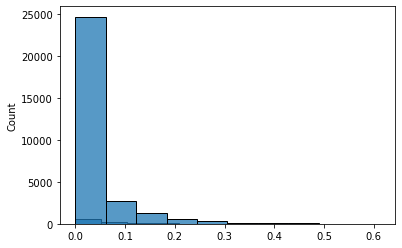

Model bert-base1
Loading tokenizer from models/hard_Information_discrete_Normalized_distil/bert-base1


KeyboardInterrupt: 

In [10]:
for iteration in range(0, 3):
    outputs = []
    outputs_test = []
    
    for model_name in MODEL_CLASSES:
        print ("==========================================")
        print ("Model {}".format(model_name))
        
        # paths
        model_path = path.join(args.model_path, model_name)
        if not path.exists(model_path): 
            os.mkdir(model_path)
        
        iteration_path = path.join(model_path, 'run' + str(iteration))
        
        # tokenizer and dataset
        try:
            tokenizer = get_tokenizer(model_name, False)
        except:
            tokenizer = get_tokenizer(model_name, True)
        
        train_data, val_data, test_data, unlabeled_data = get_dataset(tokenizer=tokenizer,
                                                                       args=args, 
                                                                       config=config,
                                                                       iteration=iteration) 
        
        curr_path = iteration_path

        if path.exists(path.join(curr_path, WEIGHTS_NAME)) and not config.retrain: 
            print ("Model run {} already trained".format(iteration)) 
            model = SequenceRegressionModel(model_name=model_name, model_path=curr_path).to(device) 
            model.load_state_dict(torch.load(path.join(curr_path, WEIGHTS_NAME), map_location=device))
        else:
            print ("Training model {} run {}".format(model_name, iteration)) 

            if not path.exists(curr_path):
                os.mkdir(curr_path) 

            save_tokenizer(tokenizer, model_name) 

            # data and iterator
            train_iter = get_iterator(dataset=train_data, batch_size=args.batch_size, shuffle=True, weighted=True)
            valid_iter = get_iterator(dataset=val_data, batch_size=args.eval_bs, shuffle=True, weighted=True)

            # model and train
            model = SequenceRegressionModel(model_name=model_name).to(device)
            tb_writer = SummaryWriter(log_dir='runs/hard_normalized_distil_' + model_name + "_" + str(iteration))
            train(model=model, 
                    model_path=curr_path, 
                    early_stopping_thresh=None,
                    iteration=iteration, num_epochs=args.num_epochs,
                    learning_rate=args.learning_rate, tb_writer=tb_writer,
                    train_loader=train_iter, valid_loader=valid_iter)
            tb_writer.close()
            
            print ("Loading the best model from {}".format(curr_path));
            model = SequenceRegressionModel(model_name=model_name, model_path=curr_path).to(device) 
            model.load_state_dict(torch.load(path.join(curr_path, WEIGHTS_NAME), map_location=device))

            # evaluation - validation
            print ("\nValidation set evaluation")
            # valid_iter = get_iterator(dataset=val_data, batch_size=args.eval_bs, shuffle=False)
            evaluate_metrics(model, valid_iter)

        # evaluation - test
        print ("\nTest set evaluation")
        test_iter = get_iterator(dataset=test_data, batch_size=args.eval_bs, shuffle=False) 
        output_test = evaluate_metrics(model, test_iter) 
        outputs_test.append(output_test[0])

        # evaluate - unlabeled
        print ("\nUnlabeled set pseudo-labelling")
        output_path = path.join(curr_path, "output.pt")
        if path.exists(output_path) and not config.retrain:
            print ("Model:{} loading labels for unlabeled data".format(model_name))
            output = torch.load(output_path)
        else:
            unlabeled_iter = get_iterator(dataset=unlabeled_data, batch_size=args.eval_bs, shuffle=False) 
            output = evaluate(model, unlabeled_iter)
            print ("Model:{} saving labels for unlabeled data".format(model_name))
            torch.save(output, output_path)

        outputs.append(output)
    
        print ("==========================================")
    
    print ("==========================================")
    print ("==========================================")
    y_test_pred, y_test_var = predict_ensemble(outputs_test)
    evaluate_test_metrics(test_iter, y_test_pred)
    
    y_pred, y_var = predict_ensemble(outputs)
    unlabeled_df = add_ensemble_data(y_pred, y_var, label=args.label, config=config, iteration=iteration)
    
    sns.histplot(y_test_var, bins=10, label="Test")
    sns.histplot(y_var, bins=10, label="Unlabeled")
    plt.show()
    print ("==========================================")

In [12]:
evaluate_test_metrics(test_iter, [0.]*len(y_test_pred))

RMSE: 0.8946199796846238
[-0.5, 0.5] range accuracy: 73.0
[-1.0, 1.0] range accuracy: 73.0


[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [ ]:
args.label = 'Thoughts_discrete'
args.model_path = 'hard_Thoughts_discrete_Normalized_distil' + args.label

print (args)

if not path.isdir(args.model_path):
    os.mkdir(args.model_path)

import json
with open(args.model_path + '/args.txt', 'w') as f:
    json.dump(args.__dict__, f, indent=2)
    
config = Config(dataset="twitter", model_home=args.model_path, do_ensemble=True)

In [ ]:
for iteration in range(0, 3):
    outputs = []
    outputs_test = []
    
    for model_name in MODEL_CLASSES:
        print ("==========================================")
        print ("Model {}".format(model_name))
        
        # paths
        model_path = path.join(args.model_path, model_name)
        if not path.exists(model_path): 
            os.mkdir(model_path)
        
        iteration_path = path.join(model_path, 'run' + str(iteration))
        
        # tokenizer and dataset
        try:
            tokenizer = get_tokenizer(model_name, False)
        except:
            tokenizer = get_tokenizer(model_name, True)
        
        train_data, val_data, test_data, unlabeled_data = get_dataset(tokenizer=tokenizer,
                                                                       args=args, 
                                                                       config=config,
                                                                       iteration=iteration) 
        
        curr_path = iteration_path

        if path.exists(path.join(curr_path, WEIGHTS_NAME)) and not config.retrain: 
            print ("Model run {} already trained".format(iteration)) 
            model = SequenceRegressionModel(model_name=model_name, model_path=curr_path).to(device) 
            model.load_state_dict(torch.load(path.join(curr_path, WEIGHTS_NAME), map_location=device))
        else:
            print ("Training model {} run {}".format(model_name, iteration)) 

            if not path.exists(curr_path):
                os.mkdir(curr_path) 

            save_tokenizer(tokenizer, model_name) 

            # data and iterator
            train_iter = get_iterator(dataset=train_data, batch_size=args.batch_size, shuffle=True, weighted=True)
            valid_iter = get_iterator(dataset=val_data, batch_size=args.eval_bs, shuffle=False)

            # model and train
            model = SequenceRegressionModel(model_name=model_name).to(device)
            tb_writer = SummaryWriter(log_dir='runs/hard_Thoughts_normalized_distil' + model_name + "_" + str(iteration))
            train(model=model, 
                    model_path=curr_path, 
                    early_stopping_thresh=None,
                    iteration=iteration, num_epochs=args.num_epochs,
                    learning_rate=args.learning_rate, tb_writer=tb_writer,
                    train_loader=train_iter, valid_loader=valid_iter)
            tb_writer.close()
            
            print ("Loading the best model from {}".format(curr_path));
            model = SequenceRegressionModel(model_name=model_name, model_path=curr_path).to(device) 
            model.load_state_dict(torch.load(path.join(curr_path, WEIGHTS_NAME), map_location=device))

            # evaluation - validation
            print ("\nValidation set evaluation")
            # valid_iter = get_iterator(dataset=val_data, batch_size=args.eval_bs, shuffle=False)
            evaluate_metrics(model, valid_iter)

        # evaluation - test
        print ("\nTest set evaluation")
        test_iter = get_iterator(dataset=test_data, batch_size=args.eval_bs, shuffle=False) 
        output_test = evaluate_metrics(model, test_iter) 
        outputs_test.append(output_test[0])

        # evaluate - unlabeled
        print ("\nUnlabeled set pseudo-labelling")
        output_path = path.join(curr_path, "output.pt")
        if path.exists(output_path) and not config.retrain:
            print ("Model:{} loading labels for unlabeled data".format(model_name))
            output = torch.load(output_path)
        else:
            unlabeled_iter = get_iterator(dataset=unlabeled_data, batch_size=args.eval_bs, shuffle=False) 
            output = evaluate(model, unlabeled_iter)
            print ("Model:{} saving labels for unlabeled data".format(model_name))
            torch.save(output, output_path)

        outputs.append(output)
    
        print ("==========================================")
    
    print ("==========================================")
    print ("==========================================")
    y_test_pred, y_test_var = predict_ensemble(outputs_test)
    evaluate_test_metrics(test_iter, y_test_pred)
    
    y_pred, y_var = predict_ensemble(outputs)
    unlabeled_df = add_ensemble_data(y_pred, y_var, label=args.label, config=config, iteration=iteration)
    
    sns.histplot(y_test_var, bins=10, label="Test")
    sns.histplot(y_var, bins=10, label="Unlabeled")
    plt.show()
    print ("==========================================")